## Example: Working with models in python

The main feature of HydroMT is to facilitate the process of building and analyzing spatial geoscientific models with a focus on water system models. It does so by automating the workflow to go from raw data to a complete model instance which is ready to run and to analyse model results once the simulation has finished. 

This notebook will explore how to work with models in HydroMT.

In [ ]:
# import hydromt and setup logging
import hydromt
from hydromt.log import setuplog

# other imports
import matplotlib.pyplot as plt
import geopandas as gpd

logger = setuplog("working with models", log_level=10)

### Available models in HydroMT

HydroMT defines any model through the model-agnostic Model API based on several components: maps, geometries, forcing, results, states and the model simulation configuration. Each component is represented with a specific Python data object to provide a common interface to different model software. While HydroMT provides several general model classes which can readily be used (e.g. LumpedModel for lumped or semi-distributed model), it can also be tailored to specific model software through a plugin infrastructure. These plugins have the same interface, but with model-specific file readers and writers and workflows.

Below is a scheme representing the Model API and general model classes available in HydroMT (without any plugin):


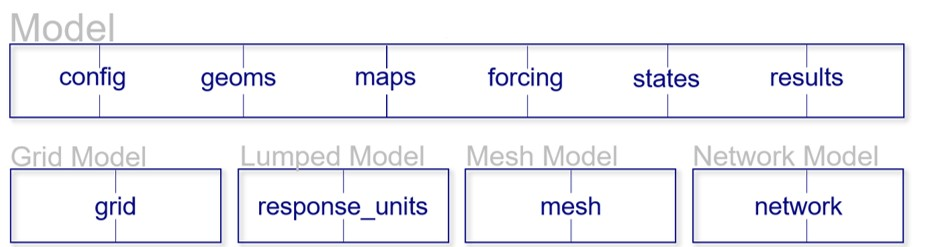

To know which models are available within your active environment, you can use the CLI:

In [ ]:
!hydromt --models

Or from python:

In [ ]:
model_catalog = hydromt.ModelCatalog()
# all model classes
print(f'All available model classes: {model_catalog.cls}')
print('')
# generic model classes
print(f'Generic model classes: {model_catalog.generic}')
print('')
# model classes from external plugin
print(f'Model classes from plugins: {model_catalog.plugins}')
print('')

Here you may only see the generic models ``grid_model``, ``lumped_model`` and ``network_model``. There is one more generic model within HydroMT ``mesh_model`` which is only available if the additional python mesh dependency *xugrid* is available in the activated environment.

### Model components

Let's discover how models are contructed within HydroMT and take the example of ``grid_model``. We will first instantiate a *mod* object from the ``GridModel`` class. The `api` property helps us discover the available components and their type:

In [ ]:
mod = hydromt.GridModel(root='grid_model')
mod.api

Here you see all the classic components from the ``Model`` class like config, geoms, forcing etc. as well as the ``GridModel`` specific component **grid**. You can see that most components are dictionnaries of either xarray DataArray or Datasets or of geopandas GeoDataFrame. For now we are starting from an empty model so all these components will be empty but here is how you can access them:

In [ ]:
mod.grid

In [ ]:
mod.geoms

### setup_ methods

To fill in our model components with data, HydroMT uses **setup** methods. These methods go from reading input data using the DataAdapter, transforming the data using workflows (e.g. reprojection, deriving parameters...) and adding the new model data to the right model component. You can view it a bit as the scheme below:

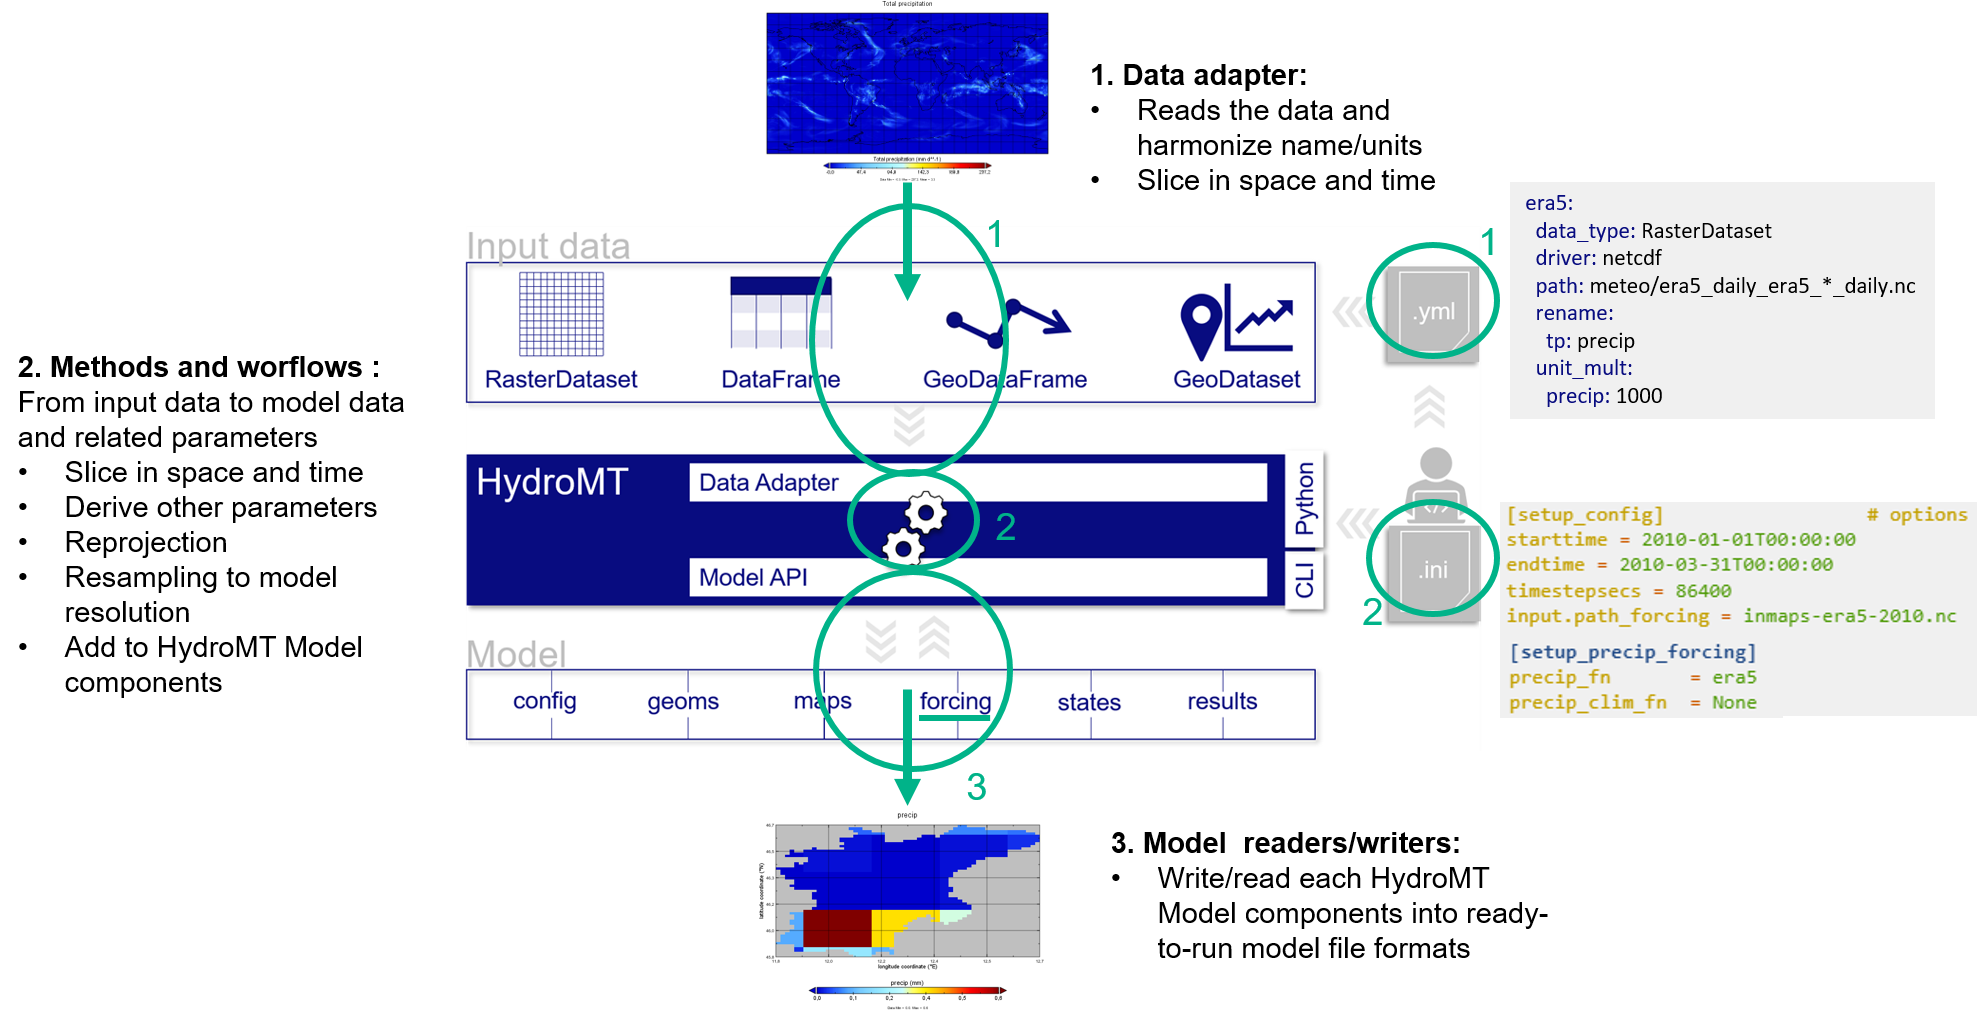

With the `get_model_components` method of HydroMT API you can see which setup / read / write methods are available for each model:

In [ ]:
from hydromt.cli import api as hydromt_api
setup_dict = hydromt_api.get_model_components(model = 'grid_model', component_types='setup')
setup_dict.keys()

The *setup_* methods are complete methods to read input data, transform it and add it to the corresponding model components. The *set_* methods are used to add data directly to the model components but does not do any reading or transformation. So the *set_* methods are for example usually used as the last steps of a *setup_* method. 

Let's have a look at some examples of the *setup_* functions to start populating our model like ``setup_region``. This method parses the [HydroMT region option](../user_guide/model_region.rst) to define the geographic region of interest of the model to build and once done adds **region** into the **geoms** component. You can check the required arguments in the [docs](../_generated/hydromt.Model.setup_region.rst) or here with our setup_dict:

In [ ]:
setup_dict['setup_region']

Let's now setup a region for our model using for example any point in the Piave basin (the ``artifact_data`` catalog is used by default).

In [ ]:
xy = [12.2051, 45.8331]
mod.setup_region(
    region = {'basin': xy},
    hydrography_fn= "merit_hydro",
    basin_index_fn="merit_hydro_index",
)
mod.geoms

In [ ]:
# Plot
fig = plt.figure(figsize=(3, 4))
ax = plt.subplot()
mod.region.boundary.plot(ax=ax)
gdf_xy = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=[xy[0]], y=[xy[1]]), crs=4326)
gdf_xy.plot(ax=ax, markersize=40, c="red", zorder=2)

Similarly, we can also populate the **config** component using the ``setup_config`` method. For HydroMT **config** represents the configuration of the model kernel, e.g. the file that would fix your model kernel run settings or list of outputs etc. For most models, this is usually a text file (for exemple .ini, .toml., .inp formats) that can be ordered in sections. Within HydroMT we then use the dictionnary object to represent each section/option/value.

Let's populate our config with some simple settings:

In [ ]:
mod.setup_config(**{
    "header": {"setting": "value"},
    "timers": {"start": "2010-02-05", "end": "2010-02-15"},
    })
mod.config

One last example available is ``setup_maps_from_raster``. This method adds data to the **maps** component based on input raster data (RasterDataset type). The **maps** component gathers any raster input data without any requirements for a specific grid schematisation (resolution and position) or projection. It can contain direct model input data for models like Delft3D-FM that will interpolate input data on the fly to the model mesh, or auxiliary data that are not used by the model kernel but can be used by HydroMT to build the model (e.g. a gridded DEM), etc.

For models that require all their input data to be resampled to the exact computation grid (all raster at the same resolution and projection), then the input data would go into the **grid** component. The corresponding *setup_* fucntions for the **grid** components are under developments.

But back to our example, let's add both a DEM map from the data source *merit_hydro_1k* and a landuse map from the data source *vito* available in the ``artifact_data`` catalogue.

In [ ]:
mod.setup_maps_from_raster(
    raster_fn='merit_hydro_1k',
    variables = 'elevtn',
    fill_method = None,
    reproject_method=None,
)
mod.setup_maps_from_raster(
    raster_fn='vito',
    fill_method = None,
    reproject_method=None,
)
mod.maps

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
mod.maps["elevtn"].raster.mask_nodata().plot(ax=axes[0],cmap="terrain")
mod.region.boundary.plot(ax=axes[0], color='k')
gdf_xy = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=[xy[0]], y=[xy[1]]), crs=4326)
gdf_xy.plot(ax=axes[0], markersize=40, c="red", zorder=2)

mod.maps["vito"].plot(ax=axes[1], cmap="terrain")
mod.region.boundary.plot(ax=axes[1], color='k')
gdf_xy.plot(ax=axes[1], markersize=40, c="red", zorder=2)

### Read / write

Once our model is filled up with data, we can then write it down using either the general ``write`` method or component specific *write_* methods. Similarly, our model can be read back with the general ``read`` method or component specific ones.

Let's see the available read and write methods for our grid_model:

In [ ]:
# Read methods
read_dict = hydromt_api.get_model_components(model = 'grid_model', component_types='read')
read_dict.keys()

In [ ]:
# Write methods
write_dict = hydromt_api.get_model_components(model = 'grid_model', component_types='write')
write_dict.keys()

*Note: staticgeoms and staticmaps are old deprecated components renamed to geoms and grid*

Let's now write our model into a *grid_model* folder:

In [ ]:
mod.write()

In [ ]:
import os

root = "grid_model"
for path, _, files in os.walk(root):
    print(path)
    for name in files:
        print(f" - {name}")

By default, **maps** is not written out for a grid_model, assuming most raster data would be transformed and added to **grid**. You can either write maps separately or within the general ``write`` method list the components you want to write:

In [ ]:
mod.write_maps()
root = "grid_model"
for path, _, files in os.walk(root):
    print(path)
    for name in files:
        print(f" - {name}")

And now let's read it back in a new grid_model instance:

In [ ]:
mod2 = hydromt.GridModel(root='grid_model', mode="r")
mod2.read(components=["config", "geoms", "maps"])
mod2.maps

### Building / updating a model with python

Using the same functionnalities, it is also possible to build or update a model within python instead of using the command line, using the ``build`` and ``update`` methods. Let's see how we could rebuild our previous *grid_model* with the ``build`` method.

First let's start with writting a HydroMT build configuration file with the components we want to build:

In [ ]:
%%writefile ./grid_model_build.ini
# This first line is used to save the ini lines below into a file called "grid_model_build.ini"

######################################################################################
####################### Content of the ini file ######################################
[setup_config]
header.settings = value
timers.start = "2010-02-05"
timers.end = "2010-02-15"

[setup_region]
# Note region argument can be passed directly from the command line
hydrography_fn = merit_hydro
basin_index_fn = merit_hydro_index

[setup_maps_from_raster]
raster_fn = merit_hydro_1k
variables = elevtn
fill_method = None
reproject_method=None

[setup_maps_from_raster1]
raster_fn = vito

[write]
components = ['config', 'geoms', 'maps']

And now let's build our model:

In [ ]:
from hydromt.cli.cli_utils import parse_config

# First we instantiate GridModel with the output folder and use the write mode (build from scratch)
model = hydromt.GridModel(root='grid_model_build', mode="w")
# Read the build configuration we just wrote
config = parse_config('grid_model_build.ini')
# Now let's build it
model.build(
    region = {'basin': xy},
    opt = config
)

In [ ]:
root = "grid_model_build"
for path, _, files in os.walk(root):
    print(path)
    for name in files:
        print(f" - {name}")

And check that the results are similar to our one-by-one setup earlier:

In [ ]:
model.config

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
model.maps["elevtn"].raster.mask_nodata().plot(ax=axes[0],cmap="terrain")
model.region.boundary.plot(ax=axes[0], color='k')

model.maps["vito"].plot(ax=axes[1], cmap="terrain")
model.region.boundary.plot(ax=axes[1], color='k')